In [48]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import BSpline
from scipy.stats import gaussian_kde

import jax.numpy as jnp
from jax import random, vmap

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")

seed = random.PRNGKey(0)

In [2]:
pos = jnp.sum(dist.Uniform(-1, 1).sample(random.PRNGKey(0), (1000, 16)), -1)

In [12]:
jnp.prod(1 + dist.Uniform(0, 0.1).sample(random.PRNGKey(0), (12,)))

DeviceArray(1.7294353, dtype=float32)

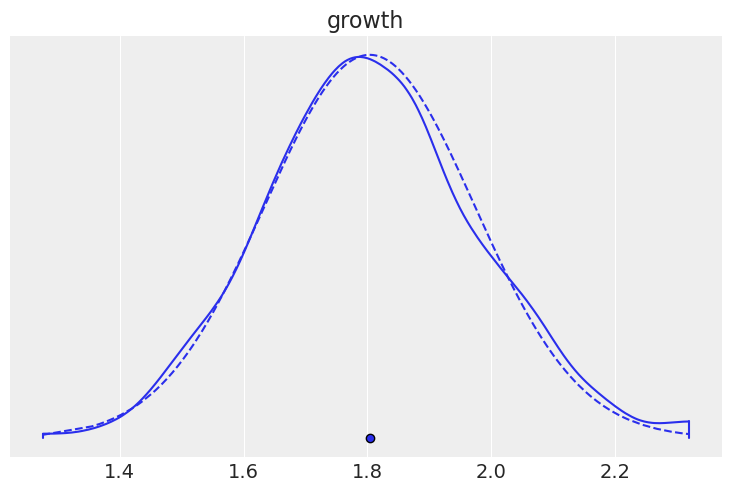

In [13]:
growth = jnp.prod(1 + dist.Uniform(0, 0.1).sample(random.PRNGKey(0), (1000, 12)), -1)
az.plot_density({"growth": growth}, hdi_prob=1)
x = jnp.sort(growth)
plt.plot(x, jnp.exp(dist.Normal(jnp.mean(x), jnp.std(x)).log_prob(x)), "--")
plt.show()

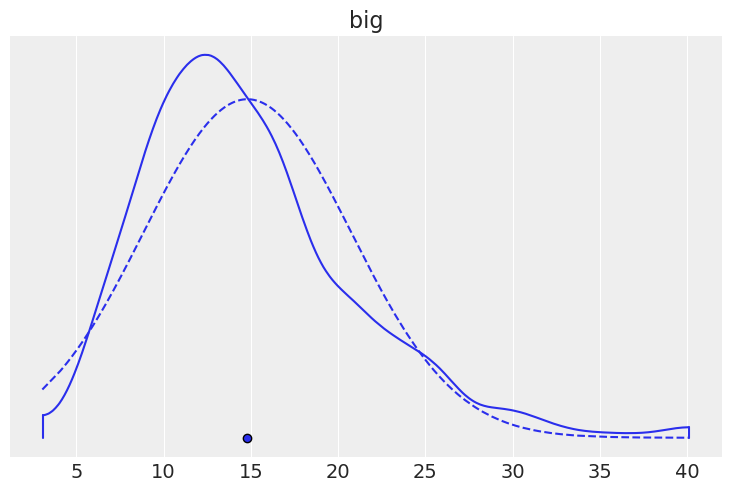

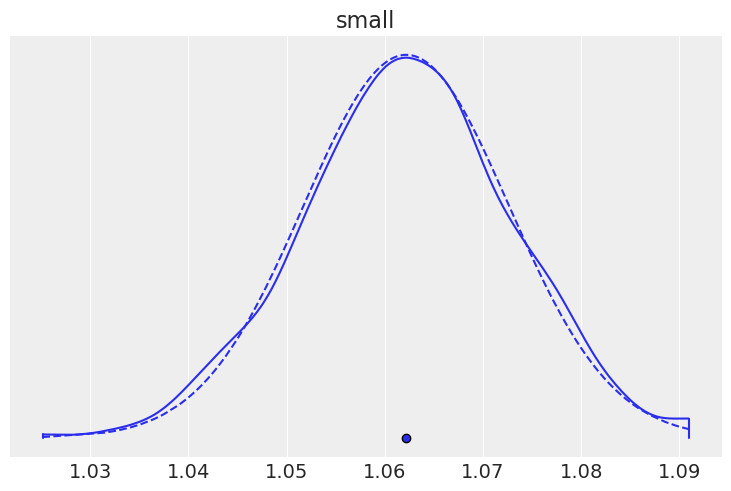

In [30]:
big = jnp.prod(1 + dist.Uniform(0, 0.5).sample(random.PRNGKey(0), (1000, 12)), -1)
small = jnp.prod(1 + dist.Uniform(0, 0.01).sample(random.PRNGKey(0), (1000, 12)), -1)
az.plot_density({"big": big}, hdi_prob=1)
x = jnp.sort(big)
plt.plot(x, jnp.exp(dist.Normal(jnp.mean(x), jnp.std(x)).log_prob(x)), "--")
az.plot_density({"small": small}, hdi_prob=1)
y = jnp.sort(small)
plt.plot(y, jnp.exp(dist.Normal(jnp.mean(y), jnp.std(y)).log_prob(y)), "--")
plt.show()


In [31]:
log_big = jnp.log(
    jnp.prod(1 + dist.Uniform(0, 0.5).sample(random.PRNGKey(0), (1000, 12)), -1)
)

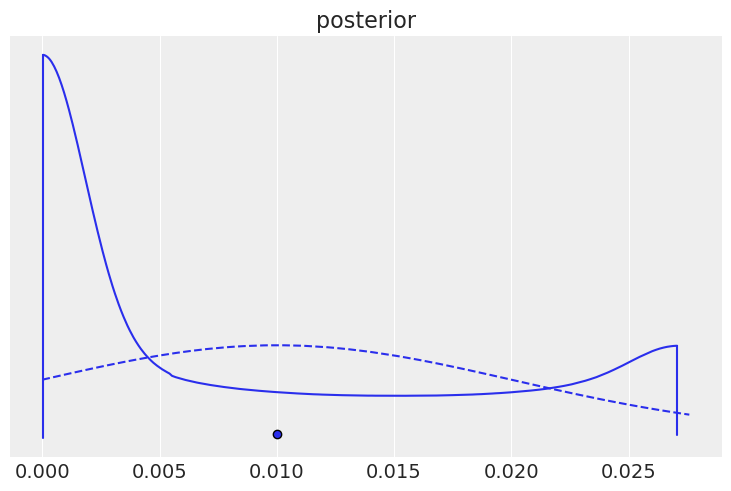

In [35]:
w = 6
n = 9
p_grid = jnp.linspace(start=0, stop=1, num=100)
prob_binom = jnp.exp(dist.Binomial(n, p_grid).log_prob(w))
posterior = prob_binom * jnp.exp(dist.Uniform(0, 1).log_prob(p_grid))
posterior = posterior / jnp.sum(posterior)
az.plot_density({"posterior": posterior})
x = jnp.sort(posterior)
plt.plot(x, jnp.exp(dist.Normal(jnp.mean(x), jnp.std(x)).log_prob(x)), "--")
plt.show()

In [36]:
howell = pd.read_csv("../data/howell1.csv")

In [40]:
print_summary(dict(zip(howell.columns, howell.T.values)), 0.89, False)


                  mean       std    median      5.5%     94.5%     n_eff     r_hat
  Unnamed: 0    272.50    157.18    272.50      1.00    485.00      2.51      2.64
         age     29.34     20.75     27.00      0.00     57.00    186.38      1.03
      height    138.26     27.60    148.59     90.81    170.18    218.68      1.06
        male      0.47      0.50      0.00      0.00      1.00    670.75      1.00
      weight     35.61     14.72     40.06     11.37     55.71    305.62      1.05



In [41]:
d2 = howell[howell.age >= 18]

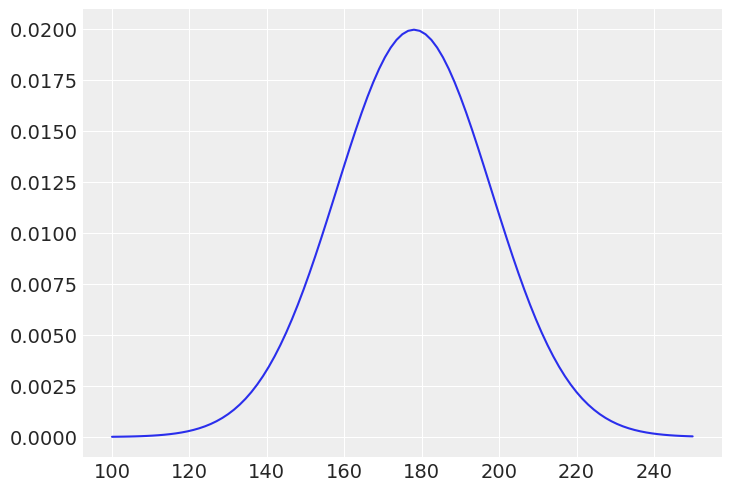

In [43]:
x = jnp.linspace(100, 250, 101)
plt.plot(x, jnp.exp(dist.Normal(178, 20).log_prob(x)))
plt.show()

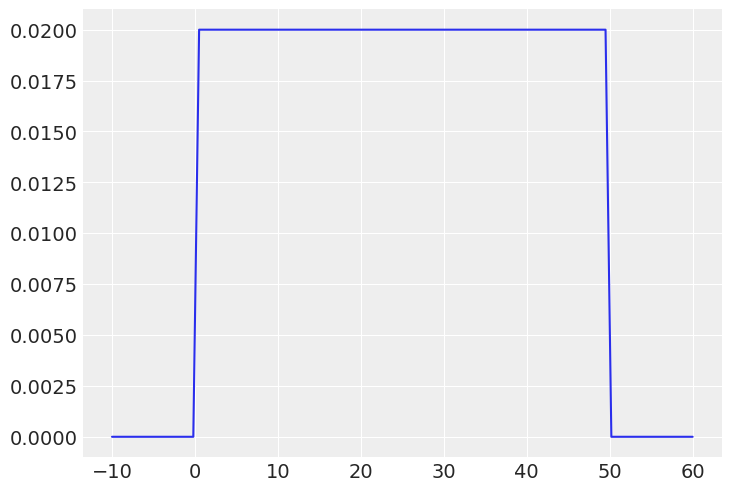

In [47]:
x = jnp.linspace(-10, 60, 101)
plt.plot(x, jnp.exp(dist.Uniform(0, 50, validate_args=True).log_prob(x)))
plt.show()

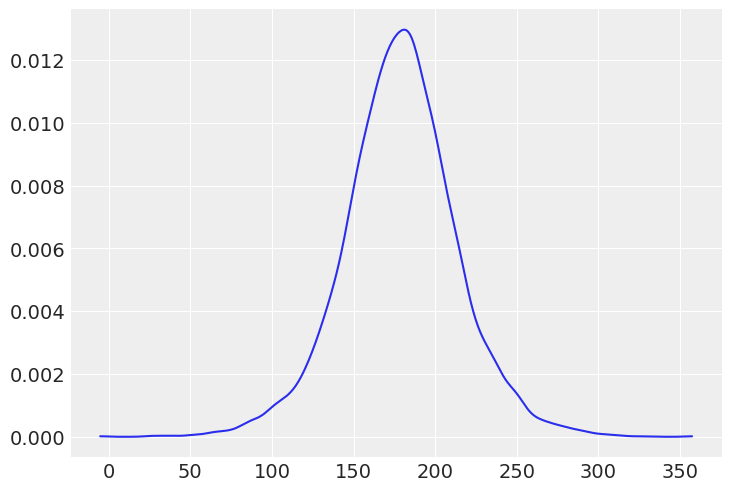

In [52]:
sample_mu = dist.Normal(178, 20).sample(seed, (int(1e4),))
sample_sigma = dist.Uniform(0, 50).sample(random.PRNGKey(1), (int(1e4),))
prior_h = dist.Normal(sample_mu, sample_sigma).sample(random.PRNGKey(2))
az.plot_kde(prior_h)
plt.show()

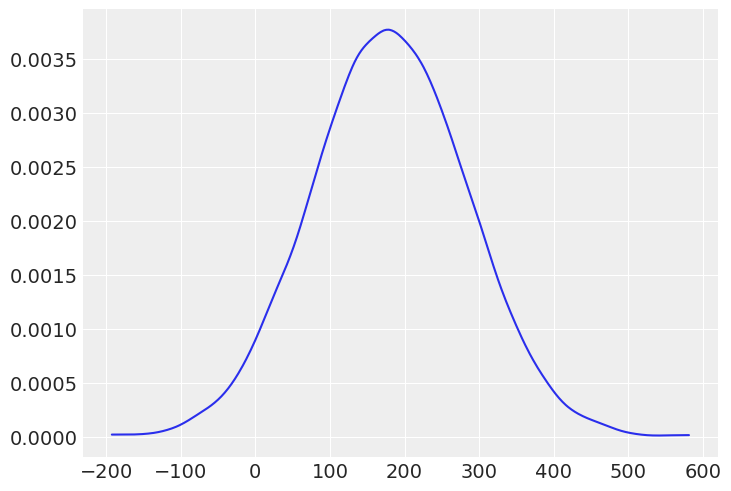

In [53]:
sample_mu_ = dist.Normal(178, 100).sample(seed, (int(1e4),))
prior_h_ = dist.Normal(sample_mu_, sample_sigma).sample(random.PRNGKey(2))
az.plot_kde(prior_h_)
plt.show()

# 4.3.3 Grid Appropximation of teh posterior distribution

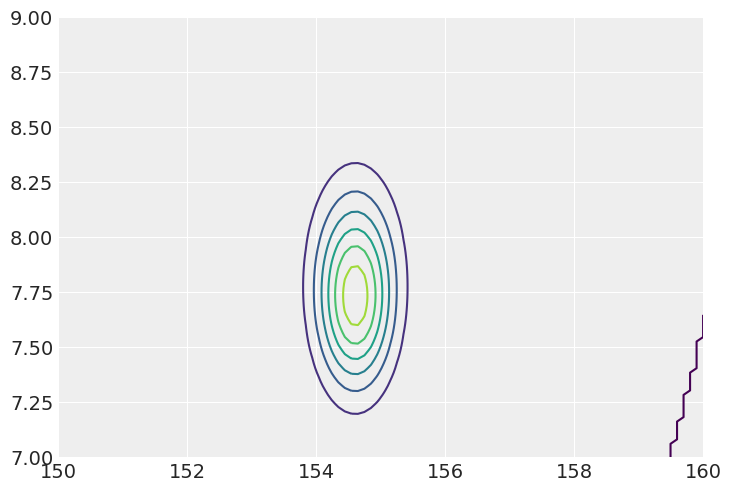

In [58]:
mu_list = jnp.linspace(start=150, stop=160, num=100)
sigma_list = jnp.linspace(start=7, stop=9, num=100)
mesh = jnp.meshgrid(mu_list, sigma_list)
post = {"mu": mesh[0].reshape(-1), "sigma": mesh[1].reshape(-1)}
post["LL"] = vmap(
    lambda mu, sigma: jnp.sum(dist.Normal(mu, sigma).log_prob(d2.height.values))
)(post["mu"], post["sigma"])
logprob_mu = dist.Normal(178, 20).log_prob(post["mu"])
logprob_sigma = dist.Uniform(0, 50).log_prob(post["sigma"])
post["prob"] = post["LL"] + logprob_mu + logprob_sigma
post["prob"] = jnp.exp(post["prob"] - jnp.max(post["prob"]))

plt.contour(
    post["mu"].reshape(100, 100),
    post["sigma"].reshape(100, 100),
    post["prob"].reshape(100, 100),
)
plt.show()

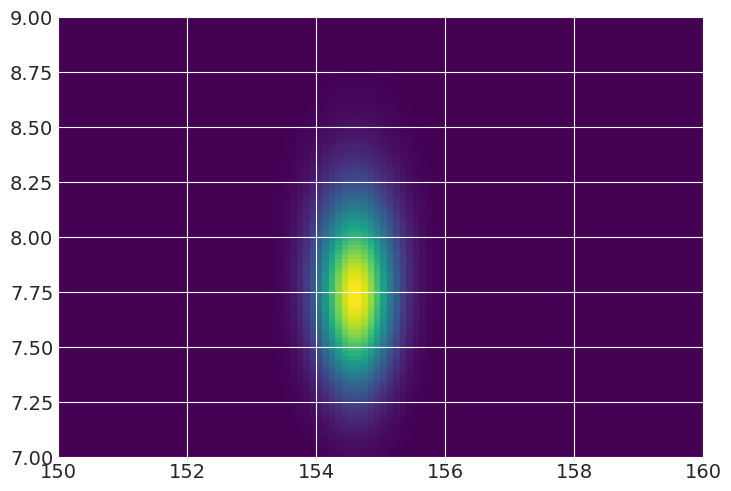

In [59]:
plt.imshow(
    post["prob"].reshape(100, 100),
    origin="lower",
    extent=(150, 160, 7, 9),
    aspect="auto",
)
plt.show()

# 4.3.4 Sampling from the posterior

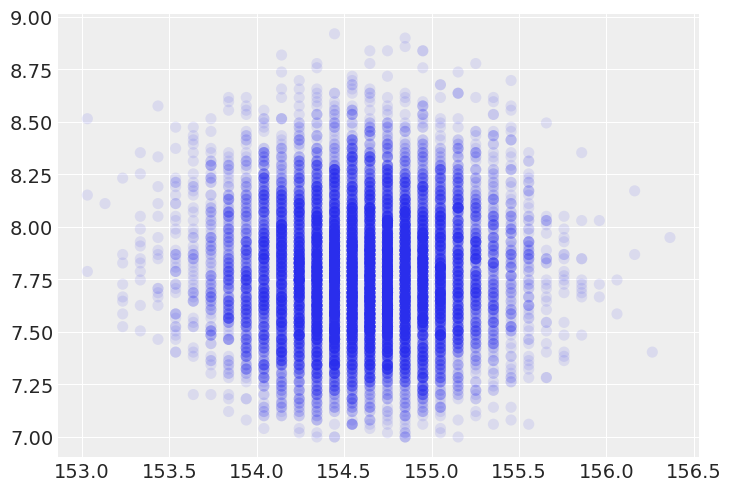

In [64]:
prob = post["prob"] / jnp.sum(post["prob"])
sample_rows = dist.Categorical(probs=prob).sample(random.PRNGKey(0), (int(1e4),))
sample_mu = post["mu"][sample_rows]
sample_sigma = post["sigma"][sample_rows]

plt.scatter(sample_mu, sample_sigma, s=64, alpha=0.1, edgecolor="none")
plt.show()

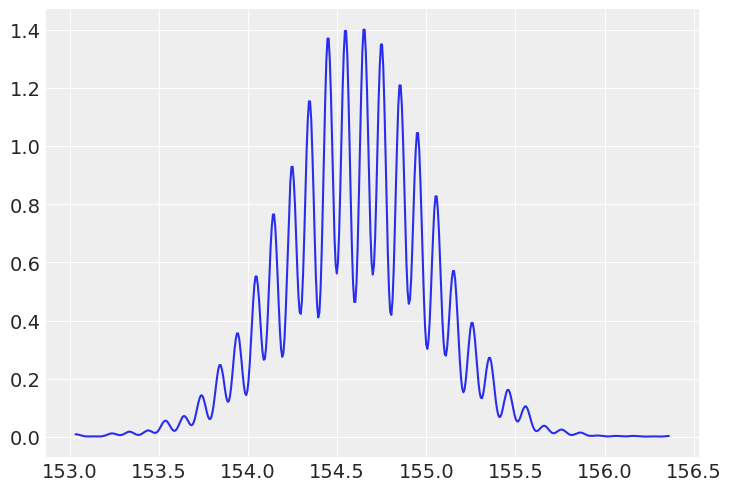

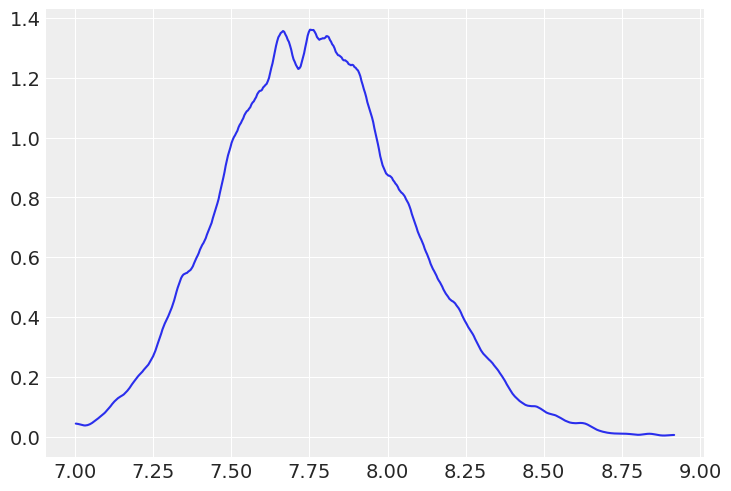

In [65]:
az.plot_kde(sample_mu)
plt.show()
az.plot_kde(sample_sigma)
plt.show()

In [66]:
print(hpdi(sample_mu, 0.89))
print(hpdi(sample_sigma, 0.89))

[153.93939 155.15152]
[7.3232327 8.252525 ]


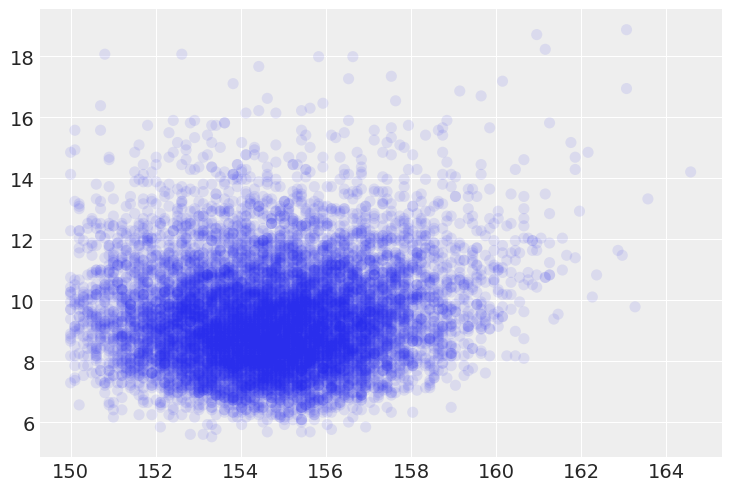

In [69]:
d3 = d2.height.sample(n=20)

mu_list = jnp.linspace(start=150, stop=170, num=200)
sigma_list = jnp.linspace(start=4, stop=20, num=200)
mesh = jnp.meshgrid(mu_list, sigma_list)
post2 = {"mu": mesh[0].reshape(-1), "sigma": mesh[1].reshape(-1)}
post2["LL"] = vmap(
    lambda mu, sigma: jnp.sum(dist.Normal(mu, sigma).log_prob(d3.values))
)(post2["mu"], post2["sigma"])
logprob_mu = dist.Normal(178, 20).log_prob(post2["mu"])
logprob_sigma = dist.Uniform(0, 50).log_prob(post2["sigma"])
post2["prob"] = post2["LL"] + logprob_mu + logprob_sigma
post2["prob"] = jnp.exp(post2["prob"] - jnp.max(post2["prob"]))
prob = post2["prob"] / jnp.sum(post2["prob"])
sample2_rows = dist.Categorical(probs=prob).sample(random.PRNGKey(0), (int(1e4),))
sample2_mu = post2["mu"][sample2_rows]
sample2_sigma = post2["sigma"][sample2_rows]
plt.scatter(sample2_mu, sample2_sigma, s=64, alpha=0.1, edgecolor="none")
plt.show()

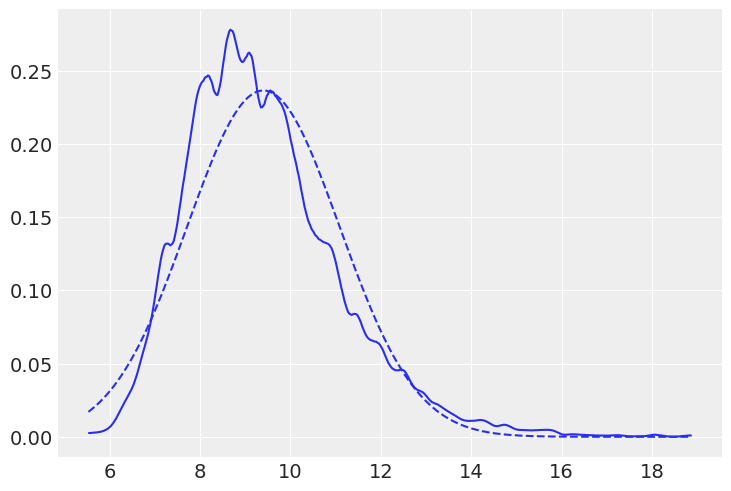

In [70]:
az.plot_kde(sample2_sigma)
x = jnp.sort(sample2_sigma)
plt.plot(x, jnp.exp(dist.Normal(jnp.mean(x), jnp.std(x)).log_prob(x)), "--")
plt.show()

In [73]:
def flist(height): 
    mu = numpyro.sample("mu", dist.Normal(178, 20))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


In [74]:
m4_1 = AutoLaplaceApproximation(flist)
svi = SVI(flist, m4_1, optim.Adam(1), Trace_ELBO(), height=d2.height.values)
p4_1, losses = svi.run(random.PRNGKey(0), 2000)

samples = m4_1.sample_posterior(random.PRNGKey(1), p4_1, (1000,))
print_summary(samples, 0.89, False)

100%|██████████| 2000/2000 [00:01<00:00, 1011.01it/s, init loss: 4000.1155, avg. loss [1901-2000]: 1226.0389]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    154.60      0.40    154.60    154.00    155.28    995.06      1.00
     sigma      7.76      0.30      7.76      7.33      8.26   1007.15      1.00



In [75]:
start = {"mu": d2.height.mean(), "sigma": d2.height.std()}
m4_1 = AutoLaplaceApproximation(flist, init_loc_fn=init_to_value(values=start))
svi = SVI(flist, m4_1, optim.Adam(0.1), Trace_ELBO(), height=d2.height.values)
p4_1, losses = svi.run(random.PRNGKey(0), 2000)

samples = m4_1.sample_posterior(random.PRNGKey(1), p4_1, (1000,))
print_summary(samples, 0.89, False)

100%|██████████| 2000/2000 [00:02<00:00, 956.55it/s, init loss: 1226.0386, avg. loss [1901-2000]: 1226.0389] 



                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    154.61      0.40    154.60    154.01    155.29    995.06      1.00
     sigma      7.76      0.30      7.76      7.33      8.26   1007.25      1.00



In [76]:
def model(height):
    mu = numpyro.sample("mu", dist.Normal(178, 0.1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

m4_2 = AutoLaplaceApproximation(model)
svi = SVI(model, m4_2, optim.Adam(1), Trace_ELBO(), height=d2.height.values)
p4_2, losses = svi.run(random.PRNGKey(0), 2000)
samples = m4_2.sample_posterior(random.PRNGKey(1), p4_2, (1000,))
print_summary(samples, 0.89, False)

100%|██████████| 2000/2000 [00:02<00:00, 683.95it/s, init loss: 1584193.6250, avg. loss [1901-2000]: 1626.5828]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    177.86      0.10    177.86    177.72    178.03    995.05      1.00
     sigma     24.57      0.94     24.60     23.01     25.96   1012.88      1.00



# 4.3.6 Sampling from a `quap`

In [77]:
samples = m4_1.sample_posterior(random.PRNGKey(1), p4_1, (1000,))
vcov = jnp.cov(jnp.stack(list(samples.values()), axis=0))
vcov

DeviceArray([[0.16249049, 0.00181413],
             [0.00181413, 0.08733188]], dtype=float32)

In [82]:
print(jnp.diagonal(vcov))
print(vcov / jnp.sqrt(jnp.outer(jnp.diagonal(vcov), jnp.diagonal(vcov))))

[0.16249049 0.08733188]
[[1.        0.0152289]
 [0.0152289 1.       ]]


In [86]:
post = m4_1.sample_posterior(random.PRNGKey(1), p4_1, (int(1e4),))
{latent: list(post[latent][:6]) for latent in post}

{'mu': [154.24832, 154.48946, 154.98318, 154.21646, 155.49542, 154.83102],
 'sigma': [7.55951, 7.3061066, 7.280058, 7.810999, 7.905513, 7.9781823]}

In [88]:
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    154.61      0.41    154.61    153.94    155.25   9926.98      1.00
     sigma      7.75      0.29      7.74      7.28      8.22   9502.46      1.00



In [89]:
samples_flat = jnp.stack(list(post.values()))
mu, sigma = jnp.mean(samples_flat), jnp.cov(samples_flat)
post = dist.MultivariateNormal(mu, sigma).sample(random.PRNGKey(0), (int(1e4),))

# 4.4 Linear Prediction

In [92]:
32 / 33

0.9696969696969697

In [93]:
13 / 14

0.9285714285714286